In [2]:
import os
import json
import pandas as pd
import numpy as np
import requests
import zipfile
from pathlib import Path
from collections import Counter
import random

os.makedirs('../data/ddxplus', exist_ok=True)
os.makedirs('../data/classifier', exist_ok=True)
os.makedirs('../models', exist_ok=True)

print("All imports successful!")
print("Directories created!")

All imports successful!
Directories created!


### Load and explore data

In [3]:
# Load conditions metadata
with open("../data/ddxplus/release_conditions.json", 'r') as f:
    conditions_data = json.load(f)

# Load evidences (symptoms) metadata
with open("../data/ddxplus/release_evidences.json", 'r') as f:
    evidences_data = json.load(f)

print("DATASET OVERVIEW")
print("=" * 50)
print(f"Number of conditions (diseases): {len(conditions_data)}")
print(f"Number of evidences (symptoms):  {len(evidences_data)}")

print("\nSAMPLE CONDITIONS:")
for i, (code, info) in enumerate(list(conditions_data.items())[:10]):
    name = info.get('cond-name-eng', code)
    print(f"   {i+1}. {name}")

print("\nSAMPLE SYMPTOMS:")
for i, (code, info) in enumerate(list(evidences_data.items())[:10]):
    name = info.get('name', code)
    print(f"   {i+1}. {name}")

DATASET OVERVIEW
Number of conditions (diseases): 49
Number of evidences (symptoms):  223

SAMPLE CONDITIONS:
   1. Spontaneous pneumothorax
   2. Cluster headache
   3. Boerhaave
   4. Spontaneous rib fracture
   5. GERD
   6. HIV (initial infection)
   7. Anemia
   8. Viral pharyngitis
   9. Inguinal hernia
   10. Myasthenia gravis

SAMPLE SYMPTOMS:
   1. E_91
   2. E_55
   3. E_53
   4. E_57
   5. E_54
   6. E_59
   7. E_56
   8. E_58
   9. E_159
   10. E_133


We have:
- 49 conditions (diseases)
- 223 symptoms (evidences)

The symptoms are showing as codes (E_91, E_55). Let's explore the actual structure to find the symptom names.

In [4]:
# Check structure of one condition
print("CONDITION STRUCTURE:")
sample_condition_code = list(conditions_data.keys())[0]
sample_condition = conditions_data[sample_condition_code]
print(f"Code: {sample_condition_code}")
print(f"Data: {json.dumps(sample_condition, indent=2)}")

print("\n\nEVIDENCE/SYMPTOM STRUCTURE:")
sample_evidence_code = list(evidences_data.keys())[0]
sample_evidence = evidences_data[sample_evidence_code]
print(f"Code: {sample_evidence_code}")
print(f"Data: {json.dumps(sample_evidence, indent=2)}")

CONDITION STRUCTURE:
Code: Spontaneous pneumothorax
Data: {
  "condition_name": "Spontaneous pneumothorax",
  "cond-name-fr": "Pneumothorax spontan\u00e9",
  "cond-name-eng": "Spontaneous pneumothorax",
  "icd10-id": "J93",
  "symptoms": {
    "E_55": {},
    "E_53": {},
    "E_57": {},
    "E_54": {},
    "E_59": {},
    "E_56": {},
    "E_58": {},
    "E_66": {},
    "E_220": {},
    "E_218": {},
    "E_14": {},
    "E_151": {}
  },
  "antecedents": {
    "E_79": {},
    "E_165": {},
    "E_21": {},
    "E_123": {},
    "E_204": {}
  },
  "severity": 2
}


EVIDENCE/SYMPTOM STRUCTURE:
Code: E_91
Data: {
  "name": "E_91",
  "code_question": "E_91",
  "question_fr": "Avez-vous objectiv\u00e9 ou ressenti de la fi\u00e8vre?",
  "question_en": "Do you have a fever (either felt or measured with a thermometer)?",
  "is_antecedent": false,
  "default_value": 0,
  "value_meaning": {},
  "possible-values": [],
  "data_type": "B"
}


The symptom names are in the question_en field. For example:
- E_91 → "Do you have a fever?"

### Create Code-to-Name Mappings

In [5]:
# Create condition code to name mapping
condition_names = {}
for code, info in conditions_data.items():
    condition_names[code] = info.get('cond-name-eng', code)

# Create evidence code to readable name mapping
# extract the key symptom from the question
def extract_symptom_name(evidence_info):
    question = evidence_info.get('question_en', '')
    
    # Remove common prefixes
    question = question.replace("Do you have ", "")
    question = question.replace("Have you ", "")
    question = question.replace("Are you ", "")
    question = question.replace("Is your ", "")
    question = question.replace("?", "")
    
    # Take first part if too long
    if len(question) > 50:
        question = question[:50] + "..."
    
    return question.strip()

evidence_names = {}
for code, info in evidences_data.items():
    evidence_names[code] = extract_symptom_name(info)

# Showing sample mappings
print("SYMPTOM CODE TO NAME MAPPING (samples):")

for code, name in list(evidence_names.items())[:15]:
    print(f"   {code}: {name}")

print(f"\nCreated mappings for {len(condition_names)} conditions")
print(f"Created mappings for {len(evidence_names)} symptoms")

SYMPTOM CODE TO NAME MAPPING (samples):
   E_91: a fever (either felt or measured with a thermomete...
   E_55: Do you feel pain somewhere
   E_53: pain somewhere, related to your reason for consult...
   E_57: Does the pain radiate to another location
   E_54: Characterize your pain:
   E_59: How fast did the pain appear
   E_56: How intense is the pain
   E_58: How precisely is the pain located
   E_159: Did you lose consciousness
   E_133: Where is the affected region located
   E_129: any lesions, redness or problems on your skin that...
   E_130: What color is the rash
   E_134: How intense is the pain caused by the rash
   E_132: Is the rash swollen
   E_136: How severe is the itching

Created mappings for 49 conditions
Created mappings for 223 symptoms


### Load Patient Training Data

In [6]:
# Extract and load training data from zip
print("Loading patient training data...")

train_zip_path = "../data/ddxplus/release_train_patients.zip"

with zipfile.ZipFile(train_zip_path, 'r') as z:
    # List files in zip
    file_list = z.namelist()
    print(f"   Files in zip: {file_list}")
    
    # Use the first file (release_train_patients)
    data_file = file_list[0]
    print(f"   Loading: {data_file}")
    
    # Load as CSV
    with z.open(data_file) as f:
        df = pd.read_csv(f)

print(f"\nLoaded {len(df):,} patient records")
print(f"\nCOLUMNS IN DATASET:")
for col in df.columns:
    print(f"   • {col}")

print(f"\nSAMPLE PATIENT RECORD:")
print(df.iloc[0])

Loading patient training data...
   Files in zip: ['release_train_patients']
   Loading: release_train_patients

Loaded 1,025,602 patient records

COLUMNS IN DATASET:
   • AGE
   • DIFFERENTIAL_DIAGNOSIS
   • SEX
   • PATHOLOGY
   • EVIDENCES
   • INITIAL_EVIDENCE

SAMPLE PATIENT RECORD:
AGE                                                                      18
DIFFERENTIAL_DIAGNOSIS    [['Bronchitis', 0.19171203430383882], ['Pneumo...
SEX                                                                       M
PATHOLOGY                                                              URTI
EVIDENCES                 ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54...
INITIAL_EVIDENCE                                                       E_91
Name: 0, dtype: object


## **EDA**

### Basic Dataset Statistics

In [7]:
print("DATASET OVERVIEW\n")

print(f"\nTotal patient records: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")

print("COLUMN DATA TYPES\n")
print(df.dtypes)


print("\nMISSING VALUES")
print(df.isnull().sum())

print("\nBASIC STATISTICS (Numerical Columns)")
print(df.describe())

DATASET OVERVIEW


Total patient records: 1,025,602
Number of columns: 6
COLUMN DATA TYPES

AGE                        int64
DIFFERENTIAL_DIAGNOSIS    object
SEX                       object
PATHOLOGY                 object
EVIDENCES                 object
INITIAL_EVIDENCE          object
dtype: object

MISSING VALUES
AGE                       0
DIFFERENTIAL_DIAGNOSIS    0
SEX                       0
PATHOLOGY                 0
EVIDENCES                 0
INITIAL_EVIDENCE          0
dtype: int64

BASIC STATISTICS (Numerical Columns)
                AGE
count  1.025602e+06
mean   3.971484e+01
std    2.271728e+01
min    0.000000e+00
25%    2.200000e+01
50%    3.900000e+01
75%    5.600000e+01
max    1.090000e+02


- Data is clean with no missing values
- Dataset covers patients of all ages (infants to elderly)
- No data cleaning required for missing values

### Condition (Disease) Distribution

CONDITION (DISEASE) DISTRIBUTION

Total unique conditions: 49
TOP 15 MOST COMMON CONDITIONS
   URTI: 64,368 (6.28%)
   Viral pharyngitis: 61,642 (6.01%)
   Anemia: 50,665 (4.94%)
   HIV (initial infection): 29,013 (2.83%)
   Localized edema: 27,825 (2.71%)
   Anaphylaxis: 27,718 (2.70%)
   Pulmonary embolism: 27,468 (2.68%)
   Influenza: 26,812 (2.61%)
   Bronchitis: 26,400 (2.57%)
   Allergic sinusitis: 26,203 (2.55%)
   Acute dystonic reactions: 25,982 (2.53%)
   GERD: 25,979 (2.53%)
   Acute otitis media: 25,917 (2.53%)
   Pneumonia: 25,761 (2.51%)
   Panic attack: 25,019 (2.44%)

BOTTOM 5 LEAST COMMON CONDITIONS
   Whooping cough: 6,070 (0.59%)
   Spontaneous rib fracture: 5,712 (0.56%)
   Croup: 2,852 (0.28%)
   Ebola: 718 (0.07%)
   Bronchiolitis: 261 (0.03%)


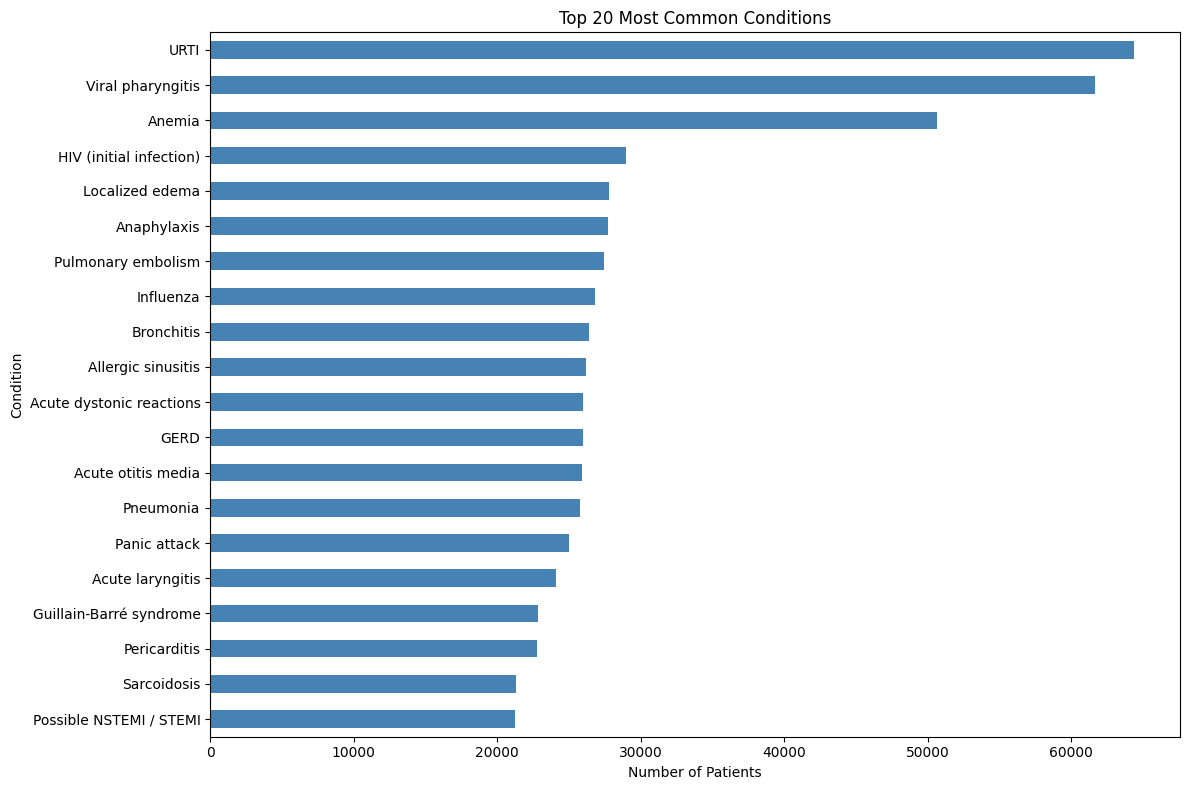

In [8]:
import matplotlib.pyplot as plt

condition_counts = df['PATHOLOGY'].value_counts()

print("CONDITION (DISEASE) DISTRIBUTION")

print(f"\nTotal unique conditions: {len(condition_counts)}")

print("TOP 15 MOST COMMON CONDITIONS")
for condition, count in condition_counts.head(15).items():
    percentage = (count / len(df)) * 100
    print(f"   {condition}: {count:,} ({percentage:.2f}%)")

print("\nBOTTOM 5 LEAST COMMON CONDITIONS")

for condition, count in condition_counts.tail(5).items():
    percentage = (count / len(df)) * 100
    print(f"   {condition}: {count:,} ({percentage:.2f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
condition_counts.head(20).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Patients')
ax.set_ylabel('Condition')
ax.set_title('Top 20 Most Common Conditions')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

| Finding           | Insight                                             |
|:-------------------|:-----------------------------------------------------|
| Total conditions  | 49 unique diseases - manageable for classification  |
| Most common       | URTI (Upper Respiratory Tract Infection) at 6.28%   |
| Distribution type | Relatively balanced - no single condition dominates |
| Top 3 conditions  | URTI, Viral pharyngitis, Anemia (~17% combined)     |
| Least common      | Bronchiolitis (0.03%), Ebola (0.07%)                |
| Class imbalance   | Present but not severe - ranges from 0.03% to 6.28% |

- Dataset covers a good mix of common conditions (flu, bronchitis) and serious ones (pulmonary embolism, anaphylaxis)
- Some class imbalance exists (rare diseases like Ebola, Bronchiolitis)
- Model may struggle with rare conditions due to fewer training examples
- For a real application, you might consider oversampling rare classes or using weighted loss

### Age Distribution

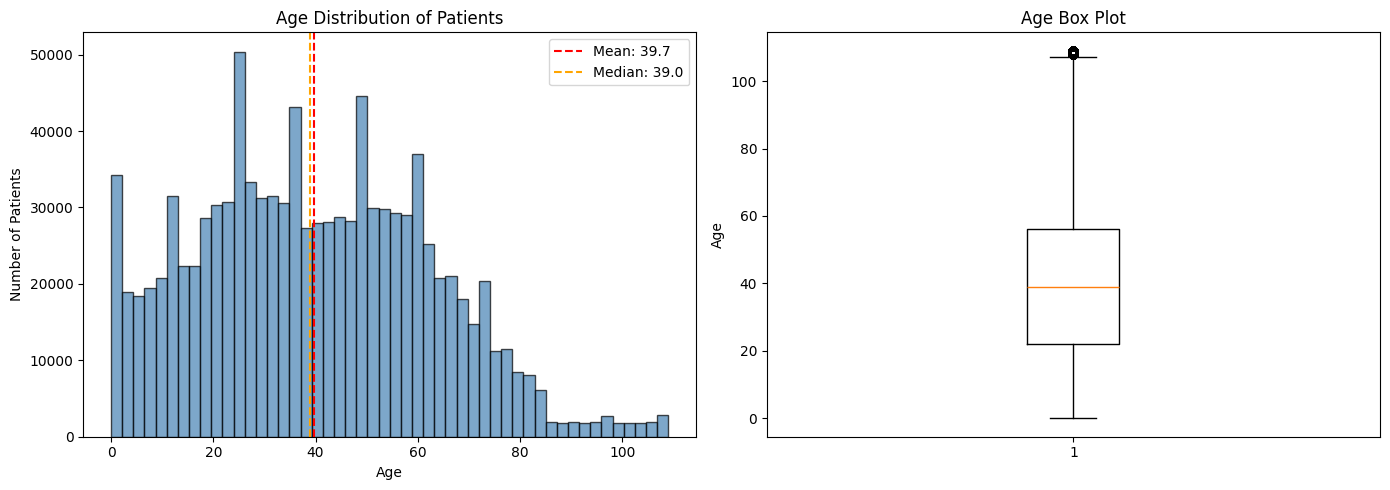

AGE GROUP BREAKDOWN
   Child (0-12): 115,797 (11.29%)
   Teen (13-18): 68,505 (6.68%)
   Young Adult (19-35): 268,026 (26.13%)
   Adult (36-50): 213,699 (20.84%)
   Middle Age (51-65): 200,987 (19.60%)
   Senior (65+): 141,628 (13.81%)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['AGE'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Number of Patients')
axes[0].set_title('Age Distribution of Patients')
axes[0].axvline(df['AGE'].mean(), color='red', linestyle='--', label=f"Mean: {df['AGE'].mean():.1f}")
axes[0].axvline(df['AGE'].median(), color='orange', linestyle='--', label=f"Median: {df['AGE'].median():.1f}")
axes[0].legend()

# Box plot
axes[1].boxplot(df['AGE'], vert=True)
axes[1].set_ylabel('Age')
axes[1].set_title('Age Box Plot')

plt.tight_layout()
plt.show()

# Age group breakdown
print("AGE GROUP BREAKDOWN")

age_bins = [0, 12, 18, 35, 50, 65, 120]
age_labels = ['Child (0-12)', 'Teen (13-18)', 'Young Adult (19-35)', 
              'Adult (36-50)', 'Middle Age (51-65)', 'Senior (65+)']

df['age_group'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels)
age_group_counts = df['age_group'].value_counts().sort_index()

for group, count in age_group_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {group}: {count:,} ({percentage:.2f}%)")

# Clean up temporary column
df.drop('age_group', axis=1, inplace=True)

| Finding       | Insight                                      |
|:---------------|:----------------------------------------------|
| Mean age      | 39.7 years                                   |
| Median age    | 39.0 years                                   |
| Mean ≈ Median | Distribution is relatively symmetric         |
| Largest group | Young Adults (19-35) at 26.13%               |
| Infant spike  | Notable peak at age 0 (visible in histogram) |
| Outliers      | Few patients above 100 years (box plot)      |


| Age Group           | Percentage | Observation             |
|:---------------------|:------------|:-------------------------|
| Child (0-12)        | 11.29%     | Good pediatric coverage |
| Teen (13-18)        | 6.68%      | Smallest group          |
| Young Adult (19-35) | 26.13%     | Largest group           |
| Adult (36-50)       | 20.84%     | Well represented        |
| Middle Age (51-65)  | 19.60%     | Well represented        |
| Senior (65+)        | 13.81%     | Good elderly coverage   |
|

- Dataset covers all age groups well
- Model will learn to diagnose conditions across different ages
- Pediatric and geriatric cases are included (important for real-world use)
- No major age bias in the dataset

### Sex Distribution

SEX DISTRIBUTION
   Female: 527,798 (51.46%)
   Male: 497,804 (48.54%)


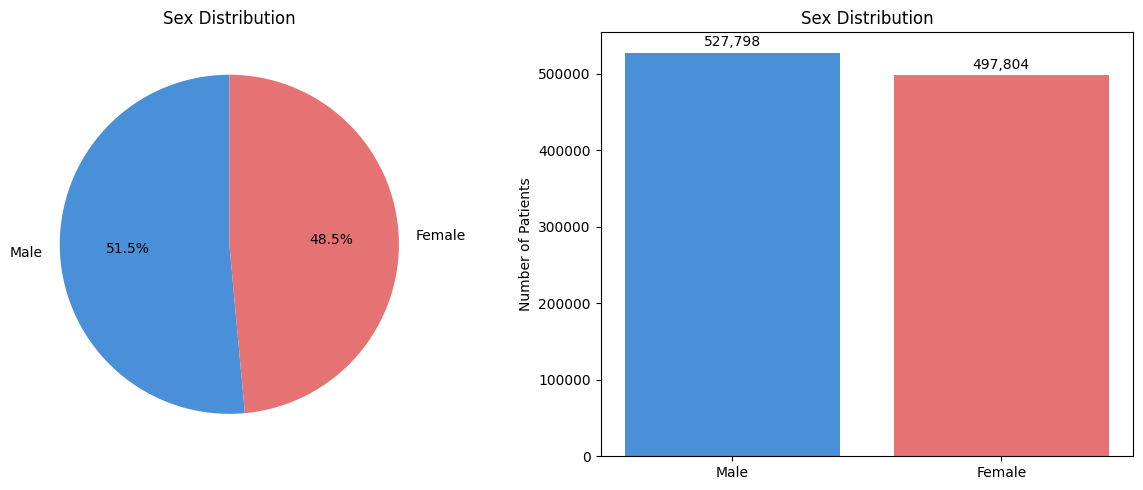

In [10]:
sex_counts = df['SEX'].value_counts()

print("SEX DISTRIBUTION")

for sex, count in sex_counts.items():
    percentage = (count / len(df)) * 100
    label = "Male" if sex == "M" else "Female"
    print(f"   {label}: {count:,} ({percentage:.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
colors = ['#4A90D9', '#E57373']
axes[0].pie(sex_counts.values, labels=['Male', 'Female'], autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('Sex Distribution')

# Bar chart
bars = axes[1].bar(['Male', 'Female'], sex_counts.values, color=colors)
axes[1].set_ylabel('Number of Patients')
axes[1].set_title('Sex Distribution')
for bar, count in zip(bars, sex_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
                 f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

- Dataset is almost perfectly balanced between male and female patients
- No gender bias in the training data
- Model will learn equally well for both sexes
- This is ideal for a medical diagnosis system

### Symptoms Per Patient

Counting symptoms per patient...
SYMPTOMS PER PATIENT

   Minimum symptoms: 2
   Maximum symptoms: 47
   Mean symptoms: 19.69
   Median symptoms: 20


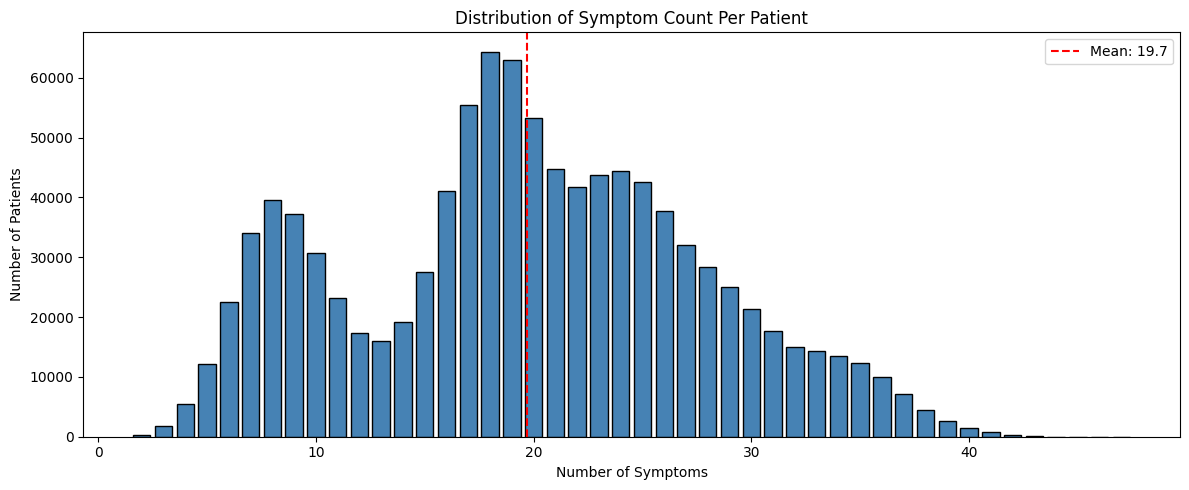

In [11]:
def count_evidences(evidences_str):
    """Count number of evidences for a patient."""
    try:
        if pd.isna(evidences_str):
            return 0
        evidences_list = eval(evidences_str)
        return len(evidences_list)
    except:
        return 0

print("Counting symptoms per patient...")
df['symptom_count'] = df['EVIDENCES'].apply(count_evidences)

print("SYMPTOMS PER PATIENT")

print(f"\n   Minimum symptoms: {df['symptom_count'].min()}")
print(f"   Maximum symptoms: {df['symptom_count'].max()}")
print(f"   Mean symptoms: {df['symptom_count'].mean():.2f}")
print(f"   Median symptoms: {df['symptom_count'].median():.0f}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 5))

symptom_count_dist = df['symptom_count'].value_counts().sort_index()
ax.bar(symptom_count_dist.index, symptom_count_dist.values, color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Symptoms')
ax.set_ylabel('Number of Patients')
ax.set_title('Distribution of Symptom Count Per Patient')
ax.axvline(df['symptom_count'].mean(), color='red', linestyle='--', label=f"Mean: {df['symptom_count'].mean():.1f}")
ax.legend()

plt.tight_layout()
plt.show()

# Clean up
df.drop('symptom_count', axis=1, inplace=True)

|Finding         |Value |
|:---------------|:-----|
|Minimum symptoms|2     |
|Maximum symptoms|47    |
|Mean symptoms   |19.69 |
|Median symptoms |20    |


- Every patient has at least 2 symptoms (no empty cases)
- On average, patients report about 20 symptoms
- Distribution is roughly normal (bell-shaped)
- Peak is around 17-20 symptoms
- This gives the model plenty of information to learn from per patient
- Real users might provide fewer symptoms, so model should handle varying input lengths


### Most Common Symptoms

Counting symptom frequencies (this may take a minute)...
TOP 20 MOST COMMON SYMPTOMS
   Do you feel pain somewhere: 3,203,271 (312.3%)
   Characterize your pain:: 1,647,421 (160.6%)
   Does the pain radiate to another location: 1,355,490 (132.2%)
   traveled out of the country in the last 4 weeks: 1,025,602 (100.0%)
   How intense is the pain: 798,938 (77.9%)
   How precisely is the pain located: 798,938 (77.9%)
   How fast did the pain appear: 798,938 (77.9%)
   pain somewhere, related to your reason for consult...: 788,079 (76.8%)
   Where is the affected region located: 618,662 (60.3%)
   experiencing shortness of breath or difficulty bre...: 399,695 (39.0%)
   Where is the swelling located: 352,462 (34.4%)
   a cough: 319,418 (31.1%)
   Do you smoke cigarettes: 287,363 (28.0%)
   a fever (either felt or measured with a thermomete...: 216,215 (21.1%)
   nasal congestion or a clear runny nose: 202,756 (19.8%)
   What color is the rash: 200,072 (19.5%)
   Do your lesions peel off: 200

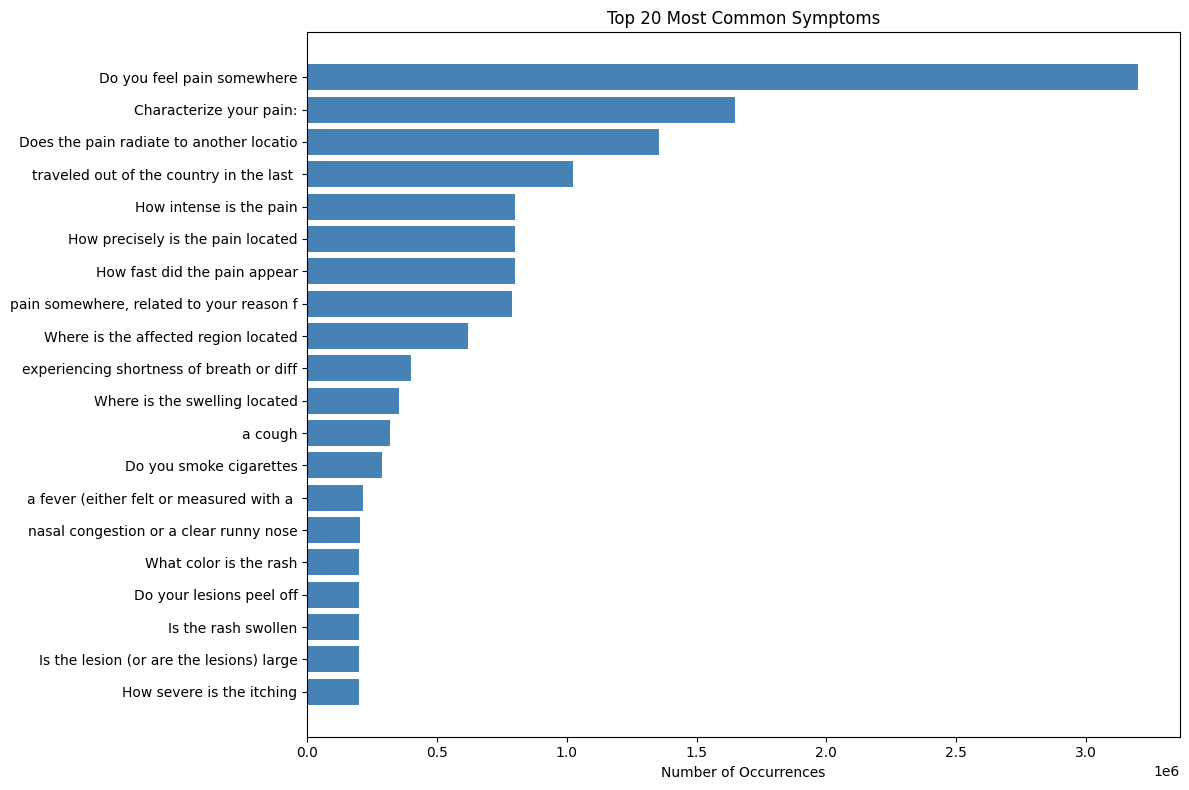

In [12]:
from collections import Counter

def extract_evidence_codes(evidences_str):
    """Extract base evidence codes from evidences string."""
    try:
        if pd.isna(evidences_str):
            return []
        evidences_list = eval(evidences_str)
        # Extract base code (remove _@_V_xxx suffix)
        base_codes = [ev.split('_@_')[0] for ev in evidences_list]
        return base_codes
    except:
        return []

print("Counting symptom frequencies (this may take a minute)...")

all_symptoms = []
for evidences_str in df['EVIDENCES']:
    codes = extract_evidence_codes(evidences_str)
    all_symptoms.extend(codes)

symptom_counts = Counter(all_symptoms)

print("=" * 60)
print("TOP 20 MOST COMMON SYMPTOMS")
print("=" * 60)

top_20_symptoms = symptom_counts.most_common(20)
for code, count in top_20_symptoms:
    symptom_name = evidence_names.get(code, code)
    # Truncate long names
    if len(symptom_name) > 50:
        symptom_name = symptom_name[:50] + "..."
    percentage = (count / len(df)) * 100
    print(f"   {symptom_name}: {count:,} ({percentage:.1f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

top_20_codes = [code for code, count in top_20_symptoms]
top_20_counts = [count for code, count in top_20_symptoms]
top_20_names = [evidence_names.get(code, code)[:40] for code in top_20_codes]

ax.barh(range(len(top_20_names)), top_20_counts, color='steelblue')
ax.set_yticks(range(len(top_20_names)))
ax.set_yticklabels(top_20_names)
ax.set_xlabel('Number of Occurrences')
ax.set_title('Top 20 Most Common Symptoms')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

| Finding            | Insight                                            |
|:-------------------|:---------------------------------------------------|
| Most common        | Pain-related questions dominate the dataset        |
| 100% occurrence    | "Traveled out of country" - asked to every patient |
| Percentages > 100% | Because patients have multiple symptoms each       |


| Category     | Examples                                       |
|:-------------|:-----------------------------------------------|
| Pain-related | Location, intensity, radiation, speed of onset |
| Respiratory  | Shortness of breath, cough, nasal congestion   |
| Skin-related | Rash color, swelling, lesions, itching         |
| General      | Fever, travel history, smoking                 |

- Dataset is based on a structured medical questionnaire (not free-form text)
- Pain is a very common complaint across many conditions
- Respiratory symptoms (cough, shortness of breath) are prevalent
- Skin symptoms form a distinct cluster
- This structure will help the model learn to ask relevant follow-up questions


### Condition vs Age Analysis

AVERAGE AGE BY CONDITION

Conditions with YOUNGEST average patients:
   Bronchiolitis: 0.3 years
   Croup: 4.1 years
   Epiglottitis: 27.8 years
   Influenza: 36.4 years
   SLE: 37.2 years

Conditions with OLDEST average patients:
   Possible NSTEMI / STEMI: 46.5 years
   Stable angina: 46.7 years
   Acute pulmonary edema: 47.0 years
   Pulmonary neoplasm: 55.2 years
   Acute COPD exacerbation / infection: 56.0 years


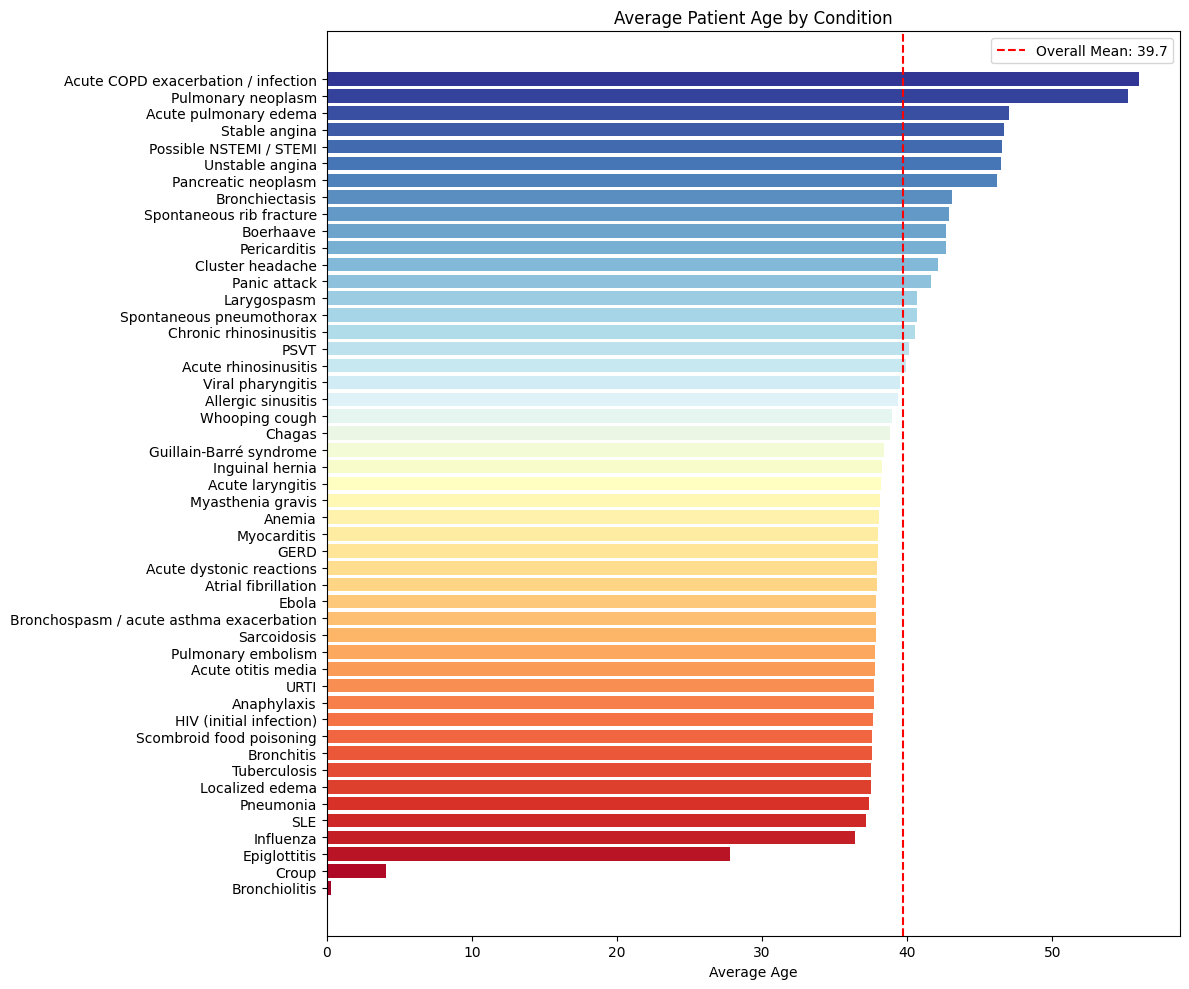

In [13]:
print("AVERAGE AGE BY CONDITION")

condition_age = df.groupby('PATHOLOGY')['AGE'].mean().sort_values()

print("\nConditions with YOUNGEST average patients:")
for condition, age in condition_age.head(5).items():
    print(f"   {condition}: {age:.1f} years")

print("\nConditions with OLDEST average patients:")
for condition, age in condition_age.tail(5).items():
    print(f"   {condition}: {age:.1f} years")

# Visualization
fig, ax = plt.subplots(figsize=(12, 10))

condition_age_sorted = condition_age.sort_values(ascending=True)
colors = plt.cm.RdYlBu(np.linspace(0, 1, len(condition_age_sorted)))

ax.barh(range(len(condition_age_sorted)), condition_age_sorted.values, color=colors)
ax.set_yticks(range(len(condition_age_sorted)))
ax.set_yticklabels(condition_age_sorted.index)
ax.set_xlabel('Average Age')
ax.set_title('Average Patient Age by Condition')
ax.axvline(df['AGE'].mean(), color='red', linestyle='--', label=f"Overall Mean: {df['AGE'].mean():.1f}")
ax.legend()

plt.tight_layout()
plt.show()

| Age Group          | Conditions                        | Medical Reasoning                                  |
|:-------------------|:----------------------------------|:---------------------------------------------------|
| Infants (0-1 yr)   | Bronchiolitis                     | Respiratory infection common in babies             |
| Children (1-5 yr)  | Croup                             | Viral infection affecting young children's airways |
| Young Adults       | Epiglottitis, Influenza, SLE      | Immune-related and infectious diseases             |
| Older Adults (45+) | Heart conditions (Angina, NSTEMI) | Cardiovascular diseases increase with age          |
| Seniors (55+)      | COPD, Pulmonary neoplasm          | Lung diseases from age and long-term exposure      |


- Dataset reflects realistic medical patterns
- Age is an important feature for diagnosis
- Pediatric conditions (Bronchiolitis, Croup) clearly separated from adult conditions
- Cardiovascular and lung diseases skew towards older patients
- Model will learn these age-condition relationships
- This validates the quality of the DDXPlus dataset



In [14]:
print("EDA SUMMARY")

print("\nDATASET OVERVIEW:")
print(f"   Total patient records: {len(df):,}")
print(f"   Number of conditions: {len(df['PATHOLOGY'].unique())}")
print(f"   Number of unique symptoms: {len(evidence_names)}")

print("\nPATIENT DEMOGRAPHICS:")
print(f"   Age range: {df['AGE'].min()} - {df['AGE'].max()} years")
print(f"   Mean age: {df['AGE'].mean():.1f} years")
print(f"   Sex ratio: {(df['SEX'] == 'M').sum() / len(df) * 100:.1f}% Male, {(df['SEX'] == 'F').sum() / len(df) * 100:.1f}% Female")

EDA SUMMARY

DATASET OVERVIEW:
   Total patient records: 1,025,602
   Number of conditions: 49
   Number of unique symptoms: 223

PATIENT DEMOGRAPHICS:
   Age range: 0 - 109 years
   Mean age: 39.7 years
   Sex ratio: 48.5% Male, 51.5% Female


DATA QUALITY:
- Missing values: None
- Class imbalance: Moderate (0.03% to 6.28%)
- Age bias: None (covers all age groups)
- Sex bias: None (nearly 50-50 split)

KEY FINDINGS FOR MODEL TRAINING:
1. Dataset is clean and ready for processing
2. 49 conditions provide good classification complexity
3. Age is an important feature (pediatric vs adult conditions)
4. Balanced sex distribution ensures fair model
5. Average 20 symptoms per patient provides rich signal
6. Some rare conditions may need special handling

## **Data Processing**

### Define Helper Functions

In [15]:
def parse_evidences(evidences_str):
    """Parse evidences string to list."""
    try:
        if pd.isna(evidences_str):
            return []
        evidences_list = eval(evidences_str)
        return evidences_list
    except:
        return []

def get_symptom_text(evidence_code):
    """Convert evidence code to readable symptom text."""
    # Remove value suffixes like _@_V_161 or _@_True
    base_code = evidence_code.split('_@_')[0]
    
    if base_code in evidences_data:
        question = evidences_data[base_code].get('question_en', '')
        # Clean up the question
        question = question.replace("Do you have ", "")
        question = question.replace("Have you ", "")
        question = question.replace("Are you ", "")
        question = question.replace("Is there ", "")
        question = question.replace("?", "")
        return question.strip()
    return None

def create_symptom_description(evidences):
    """Create natural language description from evidence codes."""
    symptom_texts = []
    
    for ev in evidences:
        symptom_text = get_symptom_text(ev)
        if symptom_text and symptom_text not in symptom_texts:
            # Limit length of individual symptoms
            if len(symptom_text) > 60:
                symptom_text = symptom_text[:60]
            symptom_texts.append(symptom_text)
    
    # Limit to first 12 symptoms to keep text manageable for model
    symptom_texts = symptom_texts[:12]
    
    if not symptom_texts:
        return ""
    
    symptoms_joined = "; ".join(symptom_texts)
    return f"Patient presents with: {symptoms_joined}"

# Test the functions
test_evidences = parse_evidences(df.iloc[0]['EVIDENCES'])
test_text = create_symptom_description(test_evidences)

print("HELPER FUNCTIONS TEST")
print(f"Sample evidences (first 5): {test_evidences[:5]}")
print(f"\nGenerated text:\n{test_text}")


HELPER FUNCTIONS TEST
Sample evidences (first 5): ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183']

Generated text:
Patient presents with: Do you live with 4 or more people; had significantly increased sweating; pain somewhere, related to your reason for consulting; Characterize your pain:; Do you feel pain somewhere; How intense is the pain; Does the pain radiate to another location; How precisely is the pain located; How fast did the pain appear; a cough that produces colored or more abundant sputum than u; Do you smoke cigarettes; a fever (either felt or measured with a thermometer)


The text generation is working. Some phrases still have "Do you" because the questions have varied formats, but this is fine for training - the model will learn from these patterns.

### Process All Patient Records

In [16]:
print("Processing all patient records...")

processed_data = []
skipped = 0

total_records = len(df)

for idx, row in df.iterrows():
    # Show progress every 100,000 records
    if idx % 100000 == 0:
        progress = (idx / total_records) * 100
        print(f"   Progress: {idx:,} / {total_records:,} ({progress:.1f}%)")
    
    # Parse evidences
    evidences = parse_evidences(row['EVIDENCES'])
    
    if not evidences:
        skipped += 1
        continue
    
    # Get condition name
    pathology = row['PATHOLOGY']
    condition_name = condition_names.get(pathology, pathology)
    
    # Create text description
    text = create_symptom_description(evidences)
    
    if not text:
        skipped += 1
        continue
    
    processed_data.append({
        'text': text,
        'condition': condition_name,
        'age': int(row['AGE']) if pd.notna(row['AGE']) else None,
        'sex': row['SEX'] if pd.notna(row['SEX']) else None,
    })

print(f"\nProcessing complete!")
print(f"   Valid records: {len(processed_data):,}")
print(f"   Skipped records: {skipped:,}")

# Show sample processed record
print("\nSample processed record:")
print(json.dumps(processed_data[0], indent=2))

Processing all patient records...
   Progress: 0 / 1,025,602 (0.0%)
   Progress: 100,000 / 1,025,602 (9.8%)
   Progress: 200,000 / 1,025,602 (19.5%)
   Progress: 300,000 / 1,025,602 (29.3%)
   Progress: 400,000 / 1,025,602 (39.0%)
   Progress: 500,000 / 1,025,602 (48.8%)
   Progress: 600,000 / 1,025,602 (58.5%)
   Progress: 700,000 / 1,025,602 (68.3%)
   Progress: 800,000 / 1,025,602 (78.0%)
   Progress: 900,000 / 1,025,602 (87.8%)
   Progress: 1,000,000 / 1,025,602 (97.5%)

Processing complete!
   Valid records: 1,025,602
   Skipped records: 0

Sample processed record:
{
  "text": "Patient presents with: Do you live with 4 or more people; had significantly increased sweating; pain somewhere, related to your reason for consulting; Characterize your pain:; Do you feel pain somewhere; How intense is the pain; Does the pain radiate to another location; How precisely is the pain located; How fast did the pain appear; a cough that produces colored or more abundant sputum than u; Do you smok

### Load Val/Test Splits

In [17]:
def load_and_process_split(zip_path, split_name):
    """Load and process a data split from zip file."""
    print(f"Loading {split_name} data...")
    
    with zipfile.ZipFile(zip_path, 'r') as z:
        file_list = z.namelist()
        data_file = file_list[0]
        
        with z.open(data_file) as f:
            df_split = pd.read_csv(f)
    
    print(f"   Loaded {len(df_split):,} records")
    
    # Process records
    processed = []
    for idx, row in df_split.iterrows():
        evidences = parse_evidences(row['EVIDENCES'])
        
        if not evidences:
            continue
        
        pathology = row['PATHOLOGY']
        condition_name = condition_names.get(pathology, pathology)
        
        text = create_symptom_description(evidences)
        
        if not text:
            continue
        
        processed.append({
            'text': text,
            'condition': condition_name,
            'age': int(row['AGE']) if pd.notna(row['AGE']) else None,
            'sex': row['SEX'] if pd.notna(row['SEX']) else None,
        })
    
    print(f"   Processed {len(processed):,} valid records")
    return processed

# Load all three splits
train_data = processed_data  # We already processed train data
print(f"Train data: {len(train_data):,} records (already processed)")

val_data = load_and_process_split(
    "../data/ddxplus/release_validate_patients.zip", 
    "validation"
)

test_data = load_and_process_split(
    "../data/ddxplus/release_test_patients.zip", 
    "test"
)

print("OFFICIAL SPLITS LOADED")
print(f"   Training set:   {len(train_data):,} records")
print(f"   Validation set: {len(val_data):,} records")
print(f"   Test set:       {len(test_data):,} records")
print(f"   Total:          {len(train_data) + len(val_data) + len(test_data):,} records")

Train data: 1,025,602 records (already processed)
Loading validation data...
   Loaded 132,448 records
   Processed 132,448 valid records
Loading test data...
   Loaded 134,529 records
   Processed 134,529 valid records
OFFICIAL SPLITS LOADED
   Training set:   1,025,602 records
   Validation set: 132,448 records
   Test set:       134,529 records
   Total:          1,292,579 records


### Create Label Mappings and Save Data

In [18]:
# Get all unique conditions
all_conditions = sorted(set(d['condition'] for d in train_data))

# Create label mappings
label2id = {condition: idx for idx, condition in enumerate(all_conditions)}
id2label = {idx: condition for condition, idx in label2id.items()}

print("LABEL MAPPINGS")
print(f"Number of classes: {len(label2id)}")
print("\nCondition to ID mapping:")
for condition, idx in label2id.items():
    print(f"   {idx:2d}: {condition}")

# Save processed data
print("\n" + "=" * 60)
print("SAVING PROCESSED DATA")
print("=" * 60)

# Save training data
train_path = "../data/classifier/train.json"
with open(train_path, 'w') as f:
    json.dump(train_data, f)
print(f"Saved: {train_path}")

# Save validation data
val_path = "../data/classifier/val.json"
with open(val_path, 'w') as f:
    json.dump(val_data, f)
print(f"Saved: {val_path}")

# Save test data
test_path = "../data/classifier/test.json"
with open(test_path, 'w') as f:
    json.dump(test_data, f)
print(f"Saved: {test_path}")

# Save label mappings
label2id_path = "../data/classifier/label2id.json"
with open(label2id_path, 'w') as f:
    json.dump(label2id, f, indent=2)
print(f"Saved: {label2id_path}")

id2label_path = "../data/classifier/id2label.json"
with open(id2label_path, 'w') as f:
    json.dump(id2label, f, indent=2)
print(f"Saved: {id2label_path}")

print("\nAll data saved successfully!")

LABEL MAPPINGS
Number of classes: 49

Condition to ID mapping:
    0: Acute COPD exacerbation / infection
    1: Acute dystonic reactions
    2: Acute laryngitis
    3: Acute otitis media
    4: Acute pulmonary edema
    5: Acute rhinosinusitis
    6: Allergic sinusitis
    7: Anaphylaxis
    8: Anemia
    9: Atrial fibrillation
   10: Boerhaave
   11: Bronchiectasis
   12: Bronchiolitis
   13: Bronchitis
   14: Bronchospasm / acute asthma exacerbation
   15: Chagas
   16: Chronic rhinosinusitis
   17: Cluster headache
   18: Croup
   19: Ebola
   20: Epiglottitis
   21: GERD
   22: Guillain-Barré syndrome
   23: HIV (initial infection)
   24: Influenza
   25: Inguinal hernia
   26: Larygospasm
   27: Localized edema
   28: Myasthenia gravis
   29: Myocarditis
   30: PSVT
   31: Pancreatic neoplasm
   32: Panic attack
   33: Pericarditis
   34: Pneumonia
   35: Possible NSTEMI / STEMI
   36: Pulmonary embolism
   37: Pulmonary neoplasm
   38: SLE
   39: Sarcoidosis
   40: Scombroid foo

## Verify Saved Files

In [19]:

print("VERIFYING SAVED FILES")

files_to_check = [
    "../data/classifier/train.json",
    "../data/classifier/val.json",
    "../data/classifier/test.json",
    "../data/classifier/label2id.json",
    "../data/classifier/id2label.json",
]

total_size = 0
for filepath in files_to_check:
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        size_mb = size / (1024 * 1024)
        total_size += size_mb
        print(f"   {filepath.split('/')[-1]:<20} {size_mb:>8.2f} MB")
    else:
        print(f"   {filepath:<20} NOT FOUND")

print(f"   {'Total:':<20} {total_size:>8.2f} MB")

# Quick verification by loading a sample
print("VERIFICATION: Loading sample from saved files")

with open("../data/classifier/train.json", 'r') as f:
    train_check = json.load(f)
    
with open("../data/classifier/label2id.json", 'r') as f:
    labels_check = json.load(f)

print(f"   Train records loaded: {len(train_check):,}")
print(f"   Labels loaded: {len(labels_check)}")
print(f"\n   Sample record:")
print(f"   Text: {train_check[0]['text'][:80]}...")
print(f"   Condition: {train_check[0]['condition']}")


VERIFYING SAVED FILES
   train.json             517.45 MB
   val.json                67.06 MB
   test.json               68.10 MB
   label2id.json            0.00 MB
   id2label.json            0.00 MB
   Total:                 652.61 MB
VERIFICATION: Loading sample from saved files
   Train records loaded: 1,025,602
   Labels loaded: 49

   Sample record:
   Text: Patient presents with: Do you live with 4 or more people; had significantly incr...
   Condition: URTI
